<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
    <h1>Team GAIASAVERS</h1>
    <h3>Alban Petit, Wafa Bouzouita,Timothée Babinet, Maxime Chor, Eric Wang, Sebastien Warichet</h3>
    <h2>Plankton classification challenge</h2>

<br>This code was tested with <br>
Python 3.7 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
     <br>
       
According to [NRMA15], a link has been found between the quality of water and the presence of plankton in said water. As water quality increases, the abundance and diversity of plankton does as well. The aim of our project is to build a plankton classifier to assess water quality.

We use for this problem the Bering Sea dataset, an in situ plankton dataset published in May 2019 by Kaichang Cheng [Che19]. This datset contains 7 classes with an even spread.

        
References and credits: 
- [NRMA15] A. Nair, J.K. Reshma, A. Mathew, and A. Ashok. Effect of water quality on phytoplankton abundance in selected ponds of nedumangad block panchayat, kerala. Emer Life Sci Res, 2015.
- [Che19] K. Cheng. Bering sea dataset. https://doi.org/10.6084/m9.figshare.8146283.v3, 2019.
 <br>
</div>

<img src="images/sample.png" alt="Drawing"/>
To see more images for each class, see the "images" folder.

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [2]:
#data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_dir = 'public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


<h3>Two "feature representation"</h3>

<p>
1.
All of the images are in various shades of gray. As such, we can represent every image by a vector of 90000 (300x300) features where each feature is a float value between 0 and 255 representing the brightness of a pixel (0 being a black pixel and 255 a white one). It is also possible to reduce the size of the images to reduce the number of features as seen in figure 3 where we reduced the size to 100x100 pixels.
</p>

<tr>
    <td> <img src="images/gray.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="images/binarized.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


<p>
2. At first we will have four types of "features". Two "features" are applied on the binarized images.
    <ul>
        <li>The first is a sum of black pixels, per line and per column.
This gives us 2 vectors of size 100. These "features" are representative among others of the shape of the plankton.
For round seeders the ratio between rows and columns near the center of the image should be close.
For longer plankton the ratio will be either low or high, depending on plankton position.
        </li>
        <li>The second is the average of the pixels.
            This gives us information on the size of the plankton.
        </li>
        <li>The third feature is the variance and is applied to non-binarized images.</li>
        <li>The last feature is the length of the contour of the plankton. It is obtained by applying a sobel filter on the image. This filter will put black pixels on the contours and white ones everywhere else. We can then just compute the amount of black pixels.
    </ul>
</p>

For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


This shows the distribution of labels in the training set

In [4]:
data['target'].value_counts()

fish_larvae     1536
limacina        1536
chaetognatha    1536
medusae         1536
other           1536
copepoda        1536
euphausiids     1536
Name: target, dtype: int64

The first rows of the dataset.

In [5]:
data.head()

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length,target
0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.83871,0.83871,0.827957,0.817204,0.795699,0.774194,0.744560,0.062088,9.82,other
1,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,0.852347,0.021939,0.64,other
2,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.82000,0.90000,1.000000,1.000000,1.000000,1.000000,0.478031,0.130620,6.68,limacina
3,1.0,1.0,0.99,0.96,0.94,0.94,0.92,0.92,0.92,0.93,...,0.96000,0.99000,1.000000,1.000000,1.000000,1.000000,0.799294,0.037921,6.86,chaetognatha
4,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,0.99000,0.990000,0.990000,1.000000,1.000000,0.713423,0.065195,11.56,medusae


Some statistics about the features.

In [6]:
data.describe() 

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_93,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length
count,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,...,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000
mean,0.979279,0.977036,0.972997,0.965795,0.956058,0.946609,0.938161,0.930047,0.922546,0.914766,...,0.936903,0.943581,0.951833,0.961342,0.966297,0.970557,0.971949,0.677502,0.074303,8.117898
std,0.096922,0.098681,0.099546,0.102380,0.106950,0.113165,0.119380,0.126461,0.132001,0.138568,...,0.118902,0.114981,0.110555,0.106497,0.105424,0.104636,0.105878,0.133997,0.033898,4.244094
min,0.100000,0.050000,0.070000,0.030000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.040000,0.209394,0.001928,0.000000
25%,1.000000,1.000000,1.000000,0.990000,0.960000,0.940000,0.930000,0.916667,0.900000,0.880000,...,0.920000,0.940000,0.950000,0.980000,1.000000,1.000000,1.000000,0.582888,0.049183,5.740000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.694925,0.068188,6.720000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.782364,0.094579,9.102500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969234,0.214556,31.030000


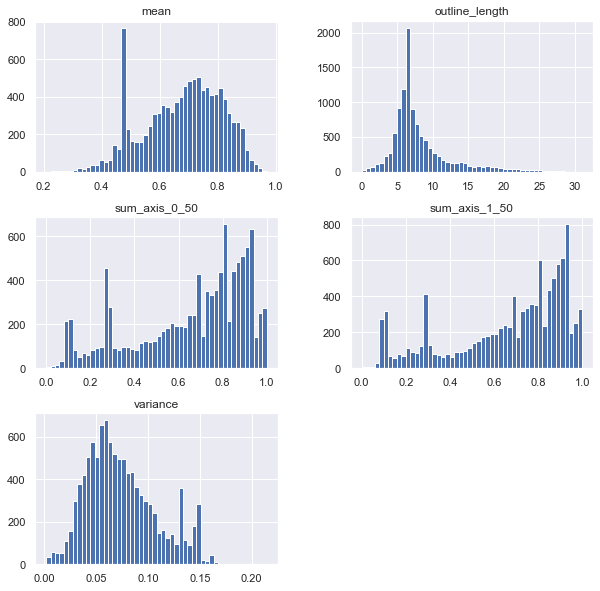

In [7]:
data[['sum_axis_0_50','sum_axis_1_50','mean','variance', 'outline_length']].hist(figsize=(10, 10), bins=50, layout=(3, 2));

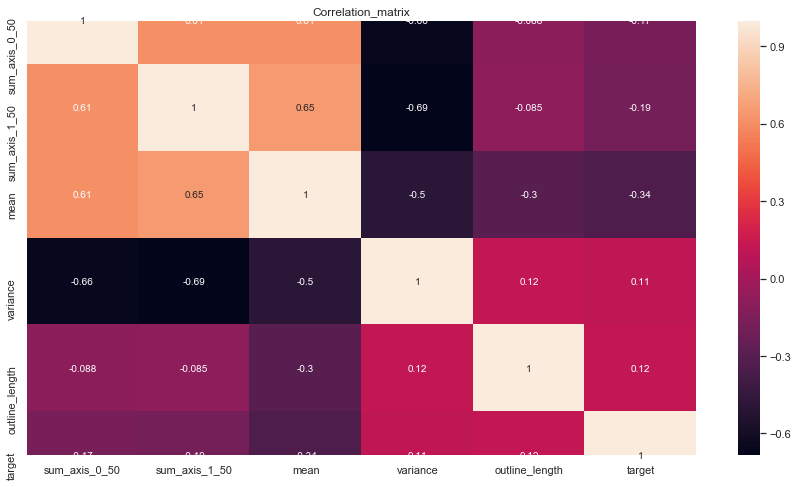

In [8]:
from sklearn import preprocessing
data_target = data.copy()
le = preprocessing.LabelEncoder()
data_target.target = le.fit_transform(data_target.target.values)
fig = plt.figure(figsize=(15,8))
sns.heatmap(data_target[['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length','target']].corr(), annot = True)
plt.title('Correlation_matrix')
plt.show()

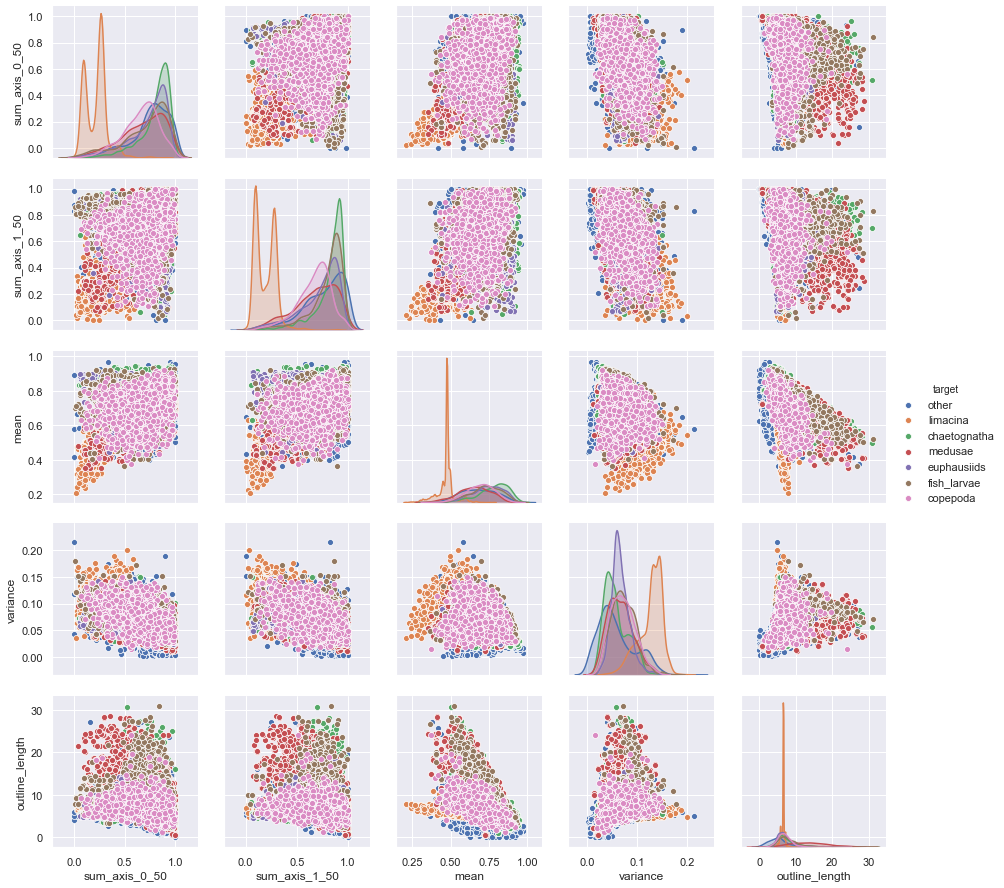

In [9]:
sns.pairplot(data,hue='target',vars=['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length'])
plt.show()

# Features Selection

<b> We initialise a new classifier </b>

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42)

<b> We create functions for Feature selection :  </b> We will thorw the worst features and compare the scoring according to the number of feature we keep to choose the better number of features

In [11]:
def ExtractData(df):
    X = np.array(df.iloc[:,:-1])
    Y = np.array(df.iloc[:,-1])
    Y = Y.reshape(Y.shape[0],1)
    return X,Y

def makeTrainAndTestData(X_donnees, Y_donnees):
    decoupe = int(2*len(X_donnees)/3)
    X_train = X_donnees[0:decoupe]
    Y_train = Y_donnees[0:decoupe]
    
    X_test = X_donnees[decoupe:]
    Y_test = Y_donnees[decoupe:]
    
    return X_train, Y_train, X_test, Y_test 

def selectFeatures(data_target, nb_features):
    '''Take a DataFrame et the number of features we want to keep and return an X and Y vectors
    representing the data and the labels'''
    corr = data_target.corr()
    print(corr['target'])
    sval = corr['target'][:-1].abs().sort_values(ascending=False)
    ranked_columns = sval.index.values
    col_selected = ranked_columns[0:nb_features]
    df = pd.DataFrame.copy(data_target)
    df = df[col_selected]
    df['target'] = data_target['target']
    X,Y = ExtractData(df)
    return X,Y

In [12]:
score = []
nbFeatures = []
nbInitialFeatures = data.columns.size - 1

for i in range(203,0, -10):
    data_fs = data.copy()
    le = preprocessing.LabelEncoder()
    data_fs.target = le.fit_transform(data_fs.target.values)
    X_fs,Y_fs = selectFeatures(data_fs, i)
    X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)
    clf.fit(X_train, Y_train)
    Y_predict =  clf.predict(X_test)
    score.append(sklearn_metric(Y_test, Y_predict))
    nbFeatures.append(i)    

sum_axis_0_0     -0.114510
sum_axis_0_1     -0.105514
sum_axis_0_2     -0.099873
sum_axis_0_3     -0.106355
sum_axis_0_4     -0.124428
                    ...   
sum_axis_1_99    -0.051875
mean             -0.342961
variance          0.110923
outline_length    0.120079
target            1.000000
Name: target, Length: 204, dtype: float64
sum_axis_0_0     -0.114510
sum_axis_0_1     -0.105514
sum_axis_0_2     -0.099873
sum_axis_0_3     -0.106355
sum_axis_0_4     -0.124428
                    ...   
sum_axis_1_99    -0.051875
mean             -0.342961
variance          0.110923
outline_length    0.120079
target            1.000000
Name: target, Length: 204, dtype: float64
sum_axis_0_0     -0.114510
sum_axis_0_1     -0.105514
sum_axis_0_2     -0.099873
sum_axis_0_3     -0.106355
sum_axis_0_4     -0.124428
                    ...   
sum_axis_1_99    -0.051875
mean             -0.342961
variance          0.110923
outline_length    0.120079
target            1.000000
Name: target, Length: 204

In [13]:
x = np.array(nbFeatures)
y = np.array(score)
y

array([0.541949  , 0.55762267, 0.56303371, 0.57000487, 0.51840312,
       0.53185609, 0.54050386, 0.5146659 , 0.52393744, 0.51815179,
       0.5131756 , 0.50514586, 0.4965284 , 0.49140352, 0.48067278,
       0.4813417 , 0.47499602, 0.47229686, 0.46448636, 0.43728527,
       0.4186827 ])

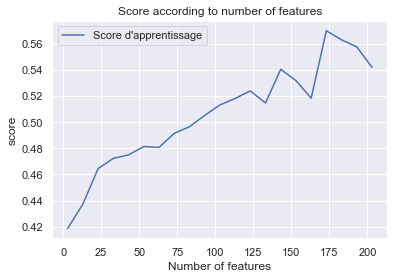

In [14]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(x,y,label = "Score d'apprentissage")

plt.title('Score according to number of features')
plt.xlabel('Number of features')
plt.ylabel('score')
plt.legend()

<b> We can clearly see that the scoring it's higher with 175 features </b>

# Dimension Reduction Using PCA

In [15]:
def dimensionReduction(X_train, fnum):
    labels= ['SV'+str(i) for i in range(1,fnum+1)]
    labels.append("target")
    pca = PCA(n_components=fnum)
    X = pca.fit_transform(X_train)
    return X, pca

In [16]:
data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
X_fs, pca = dimensionReduction(X_fs, 13)
ev = pca.explained_variance_
evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)
print(cum_evr)
print(evr)

[0.68793068 0.89506716 0.91794322 0.93229398 0.94474872 0.95517634
 0.96143394 0.96607876 0.97037389 0.97399483 0.97648872 0.97864988
 0.98074085]
[0.68793068 0.20713647 0.02287607 0.01435075 0.01245475 0.01042761
 0.0062576  0.00464482 0.00429513 0.00362094 0.0024939  0.00216115
 0.00209097]


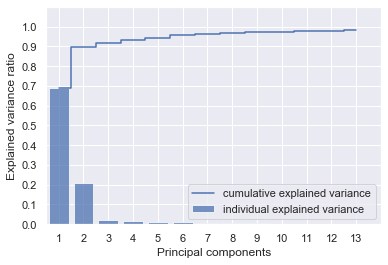

In [17]:
#code ispired by this article https://gmaclenn.github.io/articles/airport-pca-analysis/
plt.bar(list(range(1,len(evr)+1)), evr, alpha=0.75, align='center',
        label='individual explained variance')
plt.step(list(range(1,len(evr)+1)), cum_evr, where='mid',
         label='cumulative explained variance')
plt.ylim(0, 1.1)
plt.xlim(0.5,14)
plt.xticks(np.arange(1, 14, 1)) 
plt.yticks(np.arange(0.0, 1.1, 0.1)) 
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.show()

> <b> What's that mean ? : </b>

> The first two principal components combined explain 90% of the variance in the data. Afeter 10 or 11 principal components almost 100% of all variance is explained. 

Let's see if the scoring accoridng to our previous results. Actually we will used previous data with features selection and outliers deletion

In [18]:
score = []
nbFeatures = []
nbInitialFeatures = data.columns.size - 1

for i in range(1, 15, 1):
    data_fs = data.copy()
    le = preprocessing.LabelEncoder()
    data_fs.target = le.fit_transform(data_fs.target.values)
    X_fs,Y_fs = ExtractData(data_fs)
    scaler = StandardScaler()
    X_fs = scaler.fit_transform(X_fs)
    X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)

    X_train, pca = dimensionReduction(X_train, i)
    clf.fit(X_train, Y_train)
    X_test = pca.transform(X_test)
    Y_predict =  clf.predict(X_test)
    score.append(sklearn_metric(Y_test, Y_predict))
    nbFeatures.append(i)   

In [19]:
x = np.array(nbFeatures)
y = np.array(score)
y

array([0.37789552, 0.44953083, 0.49787819, 0.50051782, 0.50865688,
       0.50566979, 0.47437939, 0.48375529, 0.50492224, 0.50835915,
       0.48230469, 0.48593975, 0.48907126, 0.49342181])

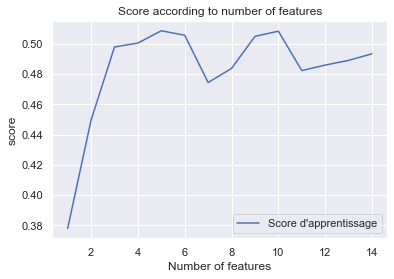

In [20]:
fig,ax = plt.subplots()
ax.plot(x,y,label = "Score d'apprentissage")

plt.title('Score according to number of features')
plt.xlabel('Number of features')
plt.ylabel('score')
plt.legend()

We can see that beyon 3 principal components the scoring start to become unpredictable. So the score start to strabilize for 3 or 4 features with a maximum on 5

In [21]:
def max_indice(x):
    maxIndice = 0
    for i in range(len(x)):
        if x[i]>x[maxIndice]:
            maxIndice = i
    return maxIndice

In [22]:
maxInd = max_indice(y)
nbFeat = x[maxInd]

In [23]:
print("the score is better with ", nbFeat, " features")

the score is better with  5  features


# Outliers detection and deletion

We Will use a PCA with a number of features of 2 features for outliers detection because it will be easier to visualize outliers ans like we have seen before 2 principal component is ok

In [24]:
nbFeat = 2

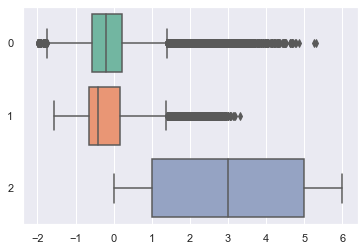

In [25]:
from sklearn.preprocessing import StandardScaler

data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
X_fs, pca = dimensionReduction(X_fs, nbFeat)
scaler = StandardScaler()
X_fs = scaler.fit_transform(X_fs)
XY = pd.DataFrame(np.append(X_fs, Y_fs, axis=1))
ax = sns.boxplot(data=XY, orient="h", palette="Set2")

### Outliers detection and visualization using IQR

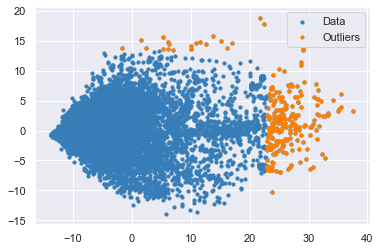

In [26]:
data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)

X_fs,Y_fs = ExtractData(data_fs)
scaler = StandardScaler()
X_fs = scaler.fit_transform(X_fs)
X_fs, pca = dimensionReduction(X_fs, 2)

XY = pd.DataFrame(np.append(X_fs, Y_fs, axis=1))
#orignaly used with 0.15 et 0.75 but that delete to much data
Q1 = XY.quantile(0.15)
Q3 = XY.quantile(0.75)
IQR = Q3 - Q1
decision = ((XY > (Q1 - 1.5 * IQR))&(XY < (Q3 + 1.5 * IQR))).all(axis=1)

X_out = X_fs[~(decision==1)]
X_in = X_fs[~(decision==-1)]
colors = np.array(['#377eb8', '#ff7f00']) #377eb8 = bleu et #ff7ff0 = orange
plt.scatter(X_in[:, 0], X_in[:, 1],color = '#377eb8' , s=10, label= "Data")
plt.scatter(X_out[:, 0], X_out[:, 1],color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

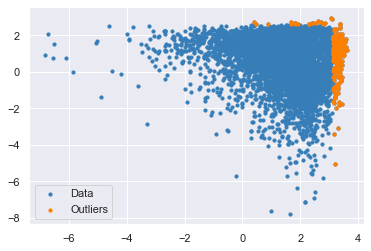

In [27]:
plt.scatter(np.log(np.abs(X_in[:, 0])), np.log(np.abs(X_in[:, 1])),color = '#377eb8' , s=10, label= "Data")
plt.scatter(np.log(np.abs(X_out[:, 0])), np.log(np.abs(X_out[:, 1])),color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

### Outliers deletion using IQR

In [28]:
def outliersIQR(X_train, Y_train, StDeviation):
    XY = pd.DataFrame(np.append(X_train, Y_train, axis=1))
    #orignaly used with 0.15 et 0.75 but that delete to much data
    Q1 = XY.quantile(0.15)
    Q3 = XY.quantile(0.75)
    IQR = Q3 - Q1
    XY = XY[~((XY < (Q1 - StDeviation * IQR)) |(XY > (Q3 + StDeviation * IQR))).any(axis=1)]
    X,Y = ExtractData(XY)
    print("Number of Data deleted = ", X_train.shape[0]-X.shape[0])
    return X,Y

In [29]:
clf = DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42)
X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)
clf.fit(X_train, Y_train)
Y_predict =  clf.predict(X_test)
scoreBefore = sklearn_metric(Y_test, Y_predict)
print("score before :", scoreBefore)
X_train, Y_train = outliersIQR(X_train, Y_train, 1.5)

score before : 0.4358955312916987
Number of Data deleted =  381


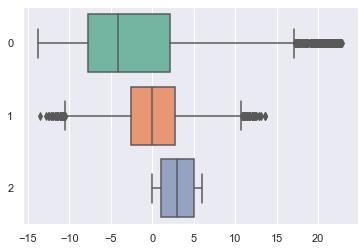

In [30]:
XY = pd.DataFrame(np.append(X_train, Y_train, axis=1))
ax = sns.boxplot(data=XY, orient="h", palette="Set2")

In [31]:
clf.fit(X_train, Y_train)
Y_predict =  clf.predict(X_test)
print("score before : ", scoreBefore, "score now : ", sklearn_metric(Y_test, Y_predict))

score before :  0.4358955312916987 score now :  0.3876190407693086


The IQR diminuing the score so we try an other method

### Outliers detection and visualization using LocalOutlierFactor

[ 1 -1  1 ...  1  1  1]


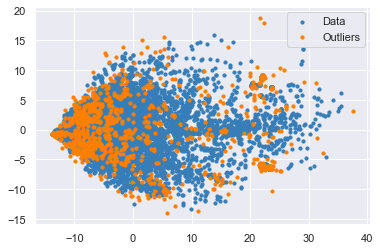

In [32]:
from sklearn.neighbors import LocalOutlierFactor

data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
scaler = StandardScaler()
X_fs = scaler.fit_transform(X_fs)
X_fs, pca = dimensionReduction(X_fs, 2)
lof = LocalOutlierFactor(n_neighbors=4)
decision = lof.fit_predict(X_fs)
print(decision)
X_in = X_fs[(decision==1)]
X_out = X_fs[(decision==-1)]
colors = np.array(['#377eb8', '#ff7f00']) #377eb8 = bleu et #ff7ff0 = orange
plt.scatter(X_in[:, 0], X_in[:, 1],color = '#377eb8' , s=10, label= "Data")
plt.scatter(X_out[:, 0], X_out[:, 1],color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

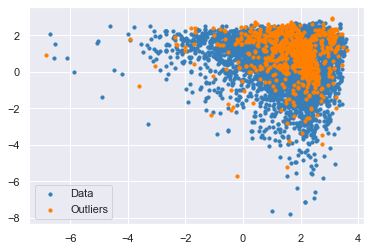

In [33]:
plt.scatter(np.log(np.abs(X_in[:, 0])), np.log(np.abs(X_in[:, 1])),color = '#377eb8' , s=10, label= "Data")
plt.scatter(np.log(np.abs(X_out[:, 0])), np.log(np.abs(X_out[:, 1])),color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

### Outliers deletion using LocalOutlierFactor

In [34]:

def LocalOutFact(X_train, Y_train, nbNeighbors):
    XY = pd.DataFrame(np.append(X_train, Y_train, axis=1))
    lof = LocalOutlierFactor(n_neighbors=nbNeighbors)
    decision = lof.fit_predict(X_train)
    XY = XY[~(decision==-1)]
    X,Y = ExtractData(XY)
    print("Number of Data deleted = ", X_train.shape[0]-X.shape[0])
    return X,Y

In [35]:
#we charge the data
score = []
nbNeighbors = np.arange(1,10,1)
for i in nbNeighbors:
    data_fs = data.copy()
    le = preprocessing.LabelEncoder()
    data_fs.target = le.fit_transform(data_fs.target.values)
    X_fs,Y_fs = ExtractData(data_fs)
    #X_fs, pca = dimensionReduction(X_fs, nbFeat)
    scaler = StandardScaler()
    X_fs = scaler.fit_transform(X_fs)
    
    X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)
    
    X_train, pca = dimensionReduction(X_train, 3)
    
    X_train, Y_train = LocalOutFact(X_train, Y_train, i)
    clf = DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42)
    X_test = pca.transform(X_test)
    clf.fit(X_train, Y_train)
    Y_predict =  clf.predict(X_test)
    score.append(sklearn_metric(Y_test, Y_predict))

Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717
Number of Data deleted =  717


In [36]:
maxInd = max_indice(score)
nbNeig = nbNeighbors[maxInd]
print("for ", nbNeig, " neighbors we have a max score of ", score[maxInd])
print("score before treatment : ", scoreBefore)

for  4  neighbors we have a max score of  0.5004066166950206
score before treatment :  0.4358955312916987


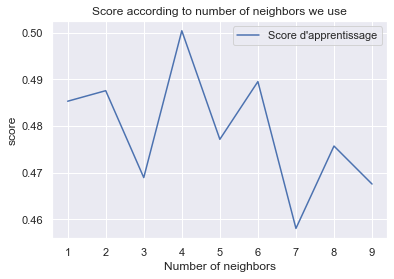

In [37]:
fig,ax = plt.subplots()
ax.plot(nbNeighbors,score,label = "Score d'apprentissage")

plt.title('Score according to number of neighbors we use')
plt.xlabel('Number of neighbors')
plt.ylabel('score')
plt.legend()

The score is higher with outliers detection. The method using LocalOutlierFactor is better than the IQR method

# Outliers detection using Z-score

In [38]:
from scipy import stats

def outliersZscore(X_train, Y_train, threshold = 3):
    XY = pd.DataFrame(np.append(X_train, Y_train, axis=1))
    z = np.abs(stats.zscore(XY))
    XY = XY[(z < threshold).all(axis=1)]
    X,Y = ExtractData(XY)
    print("Number of Data deleted = ", X_train.shape[0]-X.shape[0])
    return X,Y

[[6]
 [6]
 [4]
 ...
 [2]
 [6]
 [1]]
[ True  True  True ...  True  True  True]


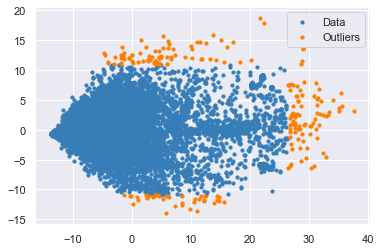

In [39]:
data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
print(Y_fs)
scaler = StandardScaler()
X_fs = scaler.fit_transform(X_fs)
X_fs, pca = dimensionReduction(X_fs, 2)
z = np.abs(stats.zscore(X_fs))
threshold = 2.5
decision = (z < threshold).all(axis=1)
print(decision)

X_out = X_fs[~(decision==True)]
X_in = X_fs[~(decision==False)]
colors = np.array(['#377eb8', '#ff7f00']) #377eb8 = bleu et #ff7ff0 = orange
plt.scatter(X_in[:, 0], X_in[:, 1],color = '#377eb8' , s=10, label= "Data")
plt.scatter(X_out[:, 0], X_out[:, 1],color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

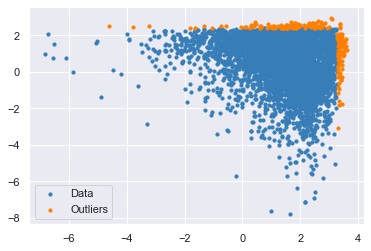

In [40]:
plt.scatter(np.log(np.abs(X_in[:, 0])), np.log(np.abs(X_in[:, 1])),color = '#377eb8' , s=10, label= "Data")
plt.scatter(np.log(np.abs(X_out[:, 0])), np.log(np.abs(X_out[:, 1])),color = '#ff7f00' , s=10, label= "Outliers")
plt.legend()

# Conclusion :

* <u>features selection :</u> The best parameters is to keep the 175 best features

* <u>Dimension Reduction :</u> With PCA the score doesn't increase if we compare to score before reduction but we highlight the fact that dimension play a role on the scoring. The 2 first principal component explain 90% of the variance on data.

* <u>Outliers deletion :</u> We tried 2 method to detect and delete outliers, the first using IQR (Interquartile Range) and the second is the LocalOutlierFactor using sklearn.neighbors. The score decrease with IQR but increase with LocalOUtliersFactor for a 2 component PCA.

## Features selction with Chi-2

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
X_fs = MinMaxScaler().fit_transform(X_fs)
print( "shape before: ",X_fs.shape)

X_fs = SelectKBest(chi2, k=175).fit_transform(X_fs, Y_fs)
print( "shape before: ",X_fs.shape)

shape before:  (10752, 203)
shape before:  (10752, 175)


In [42]:
score = []
nbFeatures = []
nbInitialFeatures = data.columns.size - 1

for i in range(203,0, -10):
    data_fs = data.copy()
    le = preprocessing.LabelEncoder()
    data_fs.target = le.fit_transform(data_fs.target.values)
    X_fs,Y_fs = ExtractData(data_fs)
    X_fs = MinMaxScaler().fit_transform(X_fs)
    X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)
    sk = SelectKBest(chi2, k=i)
    X_train = sk.fit_transform(X_train, Y_train)
    X_test = sk.transform(X_test)
    clf.fit(X_train, Y_train)
    Y_predict =  clf.predict(X_test)
    score.append(sklearn_metric(Y_test, Y_predict))
    nbFeatures.append(i)


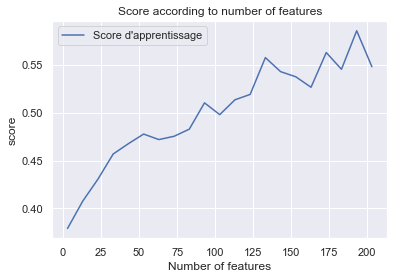

In [43]:
x = np.array(nbFeatures)
y = np.array(score)
fig,ax = plt.subplots()
ax.plot(x,y,label = "Score d'apprentissage")

plt.title('Score according to number of features')
plt.xlabel('Number of features')
plt.ylabel('score')
plt.legend()

In [44]:
maxInd = max_indice(y)
nbFeat = x[maxInd]
print(nbFeatures)

[203, 193, 183, 173, 163, 153, 143, 133, 123, 113, 103, 93, 83, 73, 63, 53, 43, 33, 23, 13, 3]


In [45]:
print( "for ", nbFeat, "we have a score of ", score[maxInd])
print("Before treatment we have a score of ", score[0])

for  193 we have a score of  0.5859551709343928
Before treatment we have a score of  0.5482556570754239


Le graphe n'est pas exploitable de manière rigoureuse car il faudrais pour celà visualiser les barre d'erreur mais même sans barre d'erreur on voit que le score est au plus de 0.6 ce qui ne relève pas d'un score particulièrement supérieur aux méthodes précédement tester pour la features Selction.

La méthode utilisant Chi-2 et Kbest ne fait pas beaucoup mieux que l'utilisation du coef de corrélation pour la sélection de variable. Mais il monte tout de même plus ahut dans le score entre 175 et 200 variable que ne le fait la selection par coeff de corélation. Donc à appronfondir à défaut de meilleurs méthodes.

## Try PCA and Features selection

5 PCA and 193 feat and outliers deletion Kneig

In [46]:
data_fs = data.copy()
le = preprocessing.LabelEncoder()
data_fs.target = le.fit_transform(data_fs.target.values)
X_fs,Y_fs = ExtractData(data_fs)
X_fs = MinMaxScaler().fit_transform(X_fs)
X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)
sk = SelectKBest(chi2, k=193)
X_train = sk.fit_transform(X_train, Y_train)
X_test = sk.transform(X_test)

X_train, pca = dimensionReduction(X_train, 5)
X_test = pca.transform(X_test)

X_train, Y_train = outliersIQR(X_train, Y_train,1.55)

clf.fit(X_train, Y_train)
Y_predict =  clf.predict(X_test)
res = sklearn_metric(Y_test, Y_predict)

Number of Data deleted =  829


In [47]:
res

0.480101892434421

# Try the Preprocessor Class

In [175]:
from preprocessing import Preprocessor
clf = DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42)

prepro = Preprocessor()
data_fs = data.copy()
X_fs,Y_fs = ExtractData(data_fs)

#séparation de X_fs et Y_fs en un ensemble d'entrainement et un ensemble de test
X_train, Y_train, X_test, Y_test = makeTrainAndTestData(X_fs, Y_fs)

#on calcul juste le score avant preprocessing pour le comparer au score après preprocessing
clf.fit(X_train, Y_train)
Y_predict =  clf.predict(X_test)
print("before : ", sklearn_metric(Y_test, Y_predict))


X_train,Y_train = prepro.outliersDeletion(X_train,Y_train) #supression des outliers dans ensemble d'entrainement
X_train = prepro.fit_transform(X_train, Y_train) #On utilise fit_transform uniquement sur ensemble d'entrainement
clf.fit(X_train, Y_train) #on entraine le classifier
X_test = prepro.transform(X_test) #on transoform notre ensemble test
Y_predict =  clf.predict(X_test) #On predit les labels de notre ensemble test
print("after : ", sklearn_metric(Y_test, Y_predict)) #on regarde le score

before :  0.5482556570754239
after :  0.5810737856928326




<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
</div>

In [48]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : C:\Users\Guild\mini-projet\PLANKTON\starting_kit\public_data\plankton_public.info
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [49]:
from data_io import write
from model import model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [50]:
# uncomment the desired model

# Decision tree model
from sklearn.tree import DecisionTreeClassifier
M = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))

trained_model_name = model_dir + data_name

# Uncomment the next line to re-load an already trained model
#M = model()
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [51]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

if not(M.is_trained):
    M.fit(X_train, Y_train)
    print('training')

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [10752, 203]
FIT: dim(y)= [10752, 1]
training
PREDICT: dim(X)= [10752, 203]
PREDICT: dim(y)= [10752, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]


In [52]:
def preprocessingFunc(fnum, StDeviation):
    M = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))

    data_target = read_as_df(data_dir  + '/' + data_name)
    data_target.target = le.fit_transform(data_target.target.values)

    trained_model_name = model_dir + data_name
    
    X_train,Y_train = featuresSlection(data_target, 200)
    #X_train,Y_train = outliersZScore(D.data['X_train'], D.data['Y_train'], StDeviation)
    X_train,Y_train = outliersZScore(X_train,Y_train, StDeviation)
    #X_train,Y_train = outliersIQR(X_train,Y_train, StDeviation)
    ##X_train = dimensionReduction(X_train, fnum)
    pca = PCA(n_components=fnum)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(D.data['X_test'])
    X_valid = pca.fit_transform(D.data['X_valid'])
    
    if not(M.is_trained):
        M.fit(X_train, Y_train)

    Y_hat_train = M.predict(X_train) # Optional, not really needed to test on training examples
    Y_hat_valid = M.predict(X_valid)
    Y_hat_test = M.predict(X_test)
    M.save(trained_model_name)                 
    result_name = result_dir + data_name
    
    return Y_train, Y_hat_train

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [53]:
#choose the best numer of feature
from libscores import get_metric
sc = []

for i in range(2,22,1):
    if(i>10):
        i+=10
    Y_train, Y_hat_train = preprocessingFunc(i, 2.3)
    metric_name, scoring_function = get_metric()
    # Uncomment the next line to display the code of the scoring metric
    #??scoring_function
    sc.append(scoring_function(Y_train, Y_hat_train))

Reading public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


NameError: name 'featuresSlection' is not defined

In [ ]:
max(sc)
sc

In [ ]:
Y_train, Y_hat_train = preprocessingFunc(4,2.3)

In [ ]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

<div style="background:#FFFFAA">
The chosen metric is the balanced accuracy. It computes the proportion of elements correctly predicted for each class. It then returns the mean of these values. The advantage of this metric is that every class is given an equal weight. <br> In our case, since all the classes are perfectly balanced, it is equivalent to simply computing the accuracy score but it the case the test set is changed and is no longer balanced, the balanced accuracy will still work properly while the accuracy score will not.
</div>

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [ ]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]
cm = confusion_matrix(Y_train, Y_hat_train)
cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix",xlabel="Predicted label",ylabel="True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)